In [253]:
import numpy as np; 
from scipy.interpolate import lagrange
import matplotlib.pyplot as plt
from scipy.special import comb
from scipy.interpolate import splev, splrep, splint,CubicSpline; 
plt.rcParams['figure.figsize'] = [15, 8];

## Spline interpolation

In [254]:
def g(x):
    return 1/(1+10*x**2);
def dg(x):
    return -20*x/(1+10*x**2)**2;
def dg2(x):
    return -20/(1+10*x**2)**2 + (800*x**2)/(1+10*x**2)**3
def dg3(x):
    return -20*dg(x) + (1600*x)/(1+10*x**2)**3 + (800*x**2)*(-3*20*x)/(1+10*x**2)**4;

### Building our own cubic spline 

In [255]:
def cubicspline(fun,n,der=0,dfun=None):
    # Interpolation pts are n+1 equispaced
    xi=np.linspace(-1,1,n+1);
    h = 2/n;     # uniform spacing h
    f = fun(xi); # function values
    # Initialize two subplots  
    fig, (ax1, ax2)  = plt.subplots(1, 2);
    if der==0:
        # Plot interpolation points as black dots
        ax1.plot(xi,f,'ok'); 
    
    # Initialize matrix A and right-hand-side rhs
    A = np.zeros((n-1,n-1)); #A is (n-1) x (n-1)
    rhs = np.zeros(n-1);     #rhs is (n-1) x 1
    ct = (6/(h**2)); #This constant appears in the rhs
    
    for i in np.arange(n-1):
        # (6/h^2) * (f[i] - 2f[i+1] + f[i+2])
        rhs[i] = ct*(f[i]-2*f[i+1]+f[i+2]);
        
        # Matrix A has 3 diagonals with values [1,4,1]
        if i==0:
            # special case for first row [4 1 0 ... 0]
            A[0,0:2]=[4,1];
        elif i==n-2:
            # special case for last row [0 0 ... 1 4]
            A[n-2,n-3:n-1]=[1,4];
        else:
            # general case [0 0 ... 1 4 1 ... 0 0]
            A[i,i-1:i+2]=[1,4,1];
    
    # We create coefficient vector a of size n+1
    a = np.zeros(n+1); 
    # (a_1,...,a_n-1) are given by the solution A^{-1}*rhs. 
    # a0 = an = 0 by the natural spline condition. 
    tmp = np.linalg.solve(A,rhs); 
    a[1:n] = tmp; 
    # b and c coefficients are functions of f(xi) and coeffs a. 
    b = f[0:n] - (1/ct)*a[0:n]; #bi = fi - (h^2/6)*ai
    c = f[1:n+1] - (1/ct)*a[1:n+1]; #ci = f_{i+1} - (h^2/6)*a_{i+1}
    
    ##############################################################################################
    #Create and plot spline pieces
    for i in np.arange(1,n+1):
        y = np.linspace(xi[i-1],xi[i],50);
        if der==0:
            # Original spline formula
            si = (a[i-1]/(6*h))*(xi[i]-y)**3 + (a[i]/(6*h))*(y-xi[i-1])**3 \
            + (b[i-1]/h)*(xi[i]-y) + (c[i-1]/h)*(y-xi[i-1]);
            ax1.plot(y,si,'b');
            ax1.set_title("cubic spline plot");
            ax2.plot(y,np.log10(np.abs(si-fun(y))+1e-16),'.r');
            ax2.set_ylim([-10,-1]);
            ax2.set_title("cubic spline log10 error");
        elif der==1:
            # 1st derivative of spline formula (pw-quadratic)
            dsi = -(a[i-1]/(2*h))*(xi[i]-y)**2 + (a[i]/(2*h))*(y-xi[i-1])**2 \ 
            + (-b[i-1]/h) + (c[i-1]/h);
            ax1.plot(y,dsi,'b');
            ax1.set_title("cubic spline 1st derivative plot");
            if dfun is not None:
                ax1.plot(xi,dfun(xi),'ok');
                ax2.plot(y,np.log10(np.abs(dsi-dfun(y))+1e-16),'.r');
                ax2.set_ylim([-10,-1]);
                ax2.set_title("cubic spline 1st derivative log10 error");
        elif der==2:
            # 2nd derivative of spline formula (pw-linear)
            dsi = (a[i-1]/(h))*(xi[i]-y) + (a[i]/(h))*(y-xi[i-1]);
            ax1.plot(y,dsi,'b');
            ax1.set_title("cubic spline 2nd derivative plot");
            if dfun is not None:
                ax1.plot(xi,dfun(xi),'ok');
                ax2.plot(y,np.log10(np.abs(dsi-dfun(y))+1e-16),'.r');
                ax2.set_ylim([-10,-1]);
                ax2.set_title("cubic spline 2nd derivative log10 error");
        elif der==3:
            # 3rd derivative of spline formula (pw-constant)
            dsi = (-(a[i-1]/(h)) + (a[i]/(h)))*np.ones(len(y));
            ax1.plot(y,dsi,'b');
            ax1.set_title("cubic spline 3rd derivative plot");
            if dfun is not None:
                ax1.plot(xi,dfun(xi),'ok');
                ax2.plot(y,np.log10(np.abs(dsi-dfun(y))+1e-16),'.r');
                ax2.set_ylim([-10,2]);
                ax2.set_title("cubic spline 3rd derivative log10 error");
    
    if der<0 or der>3:
        print("derivatives of order %d are 0 or not supported",der);
    
    return (a,b,c); 

SyntaxError: unexpected character after line continuation character (<ipython-input-255-2c380caf0c43>, line 57)

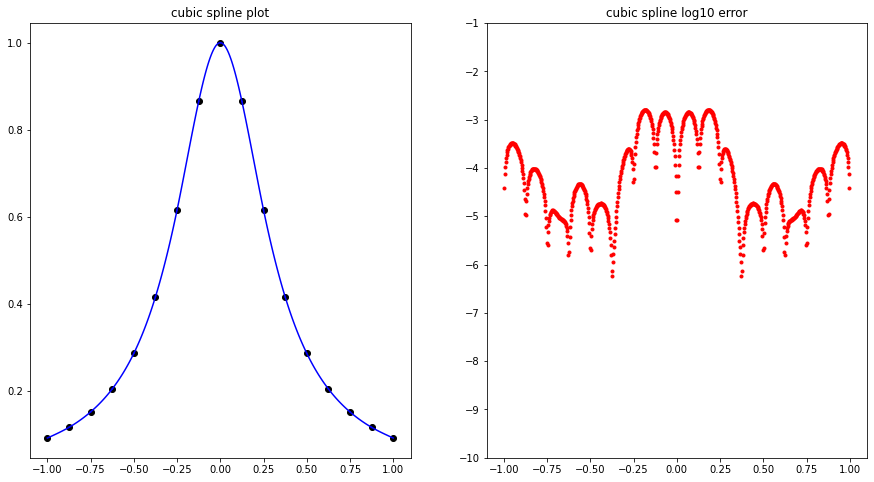

In [256]:
(an,bn,cn)=cubicspline(g,16); 

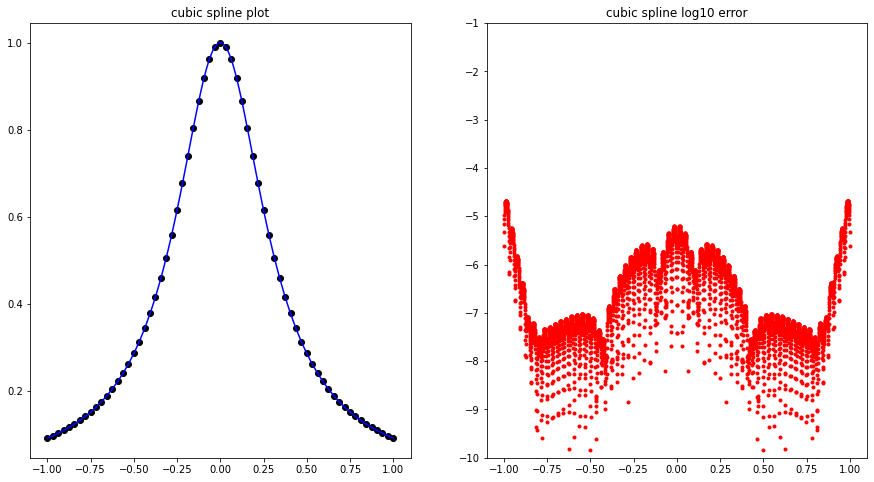

In [257]:
(an,bn,cn)=cubicspline(g,64);

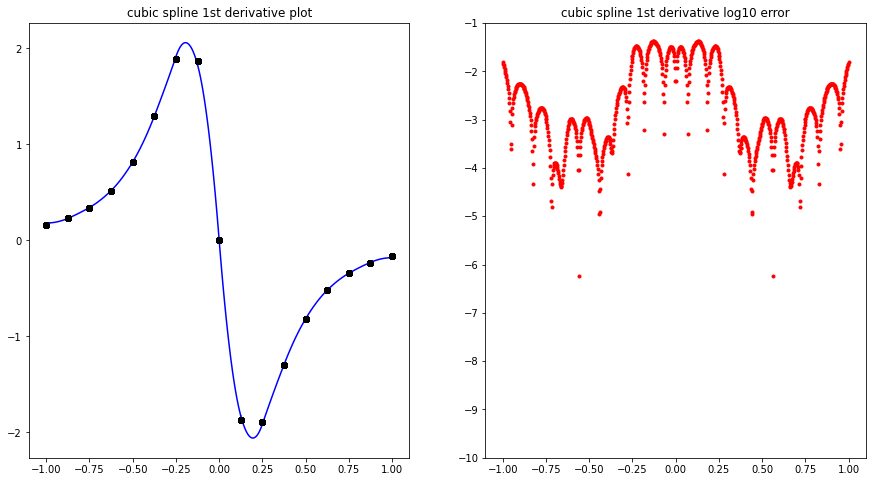

In [248]:
(an,bn,cn)=cubicspline(g,16,1,dg);

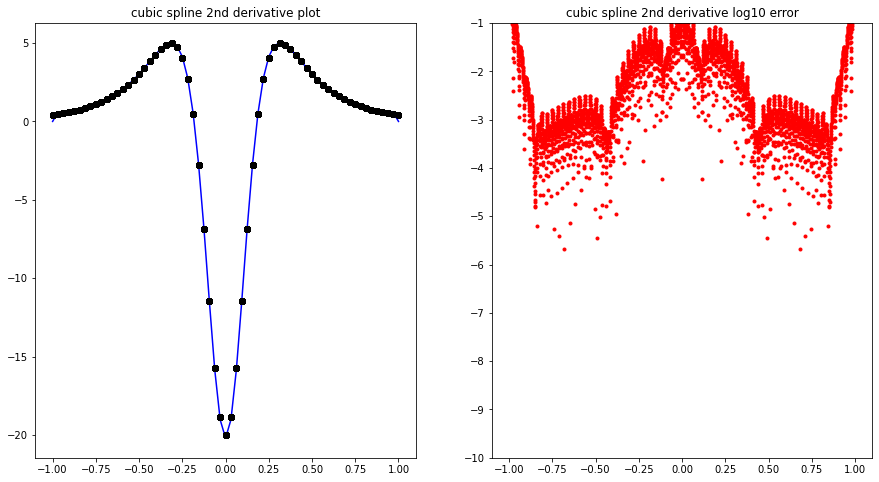

In [258]:
(an,bn,cn)=cubicspline(g,64,2,dg2);

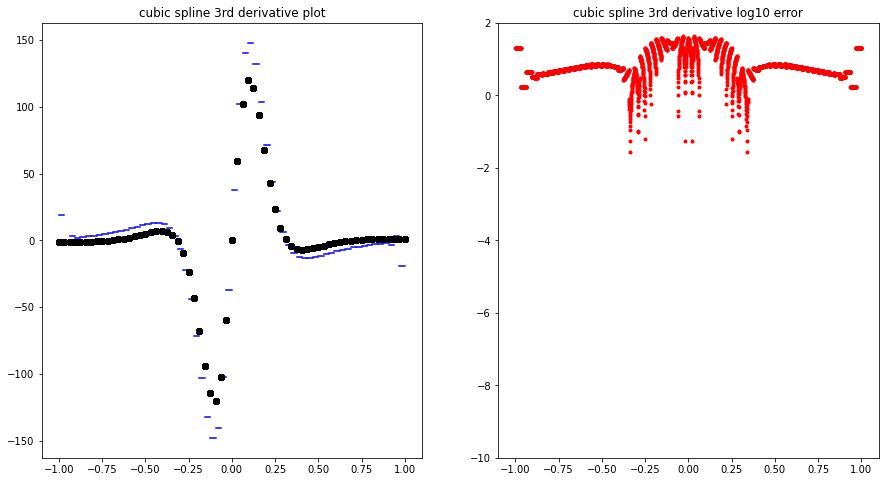

In [259]:
(an,bn,cn)=cubicspline(g,64,3,dg3);

## Using Python's spline toolboxes

In [170]:
def g2(x):
    return np.sinc(3*x); 

### (1) Scipy.Interpolation CubicSpline

Text(0.5, 1.0, 'clamped spline fit')

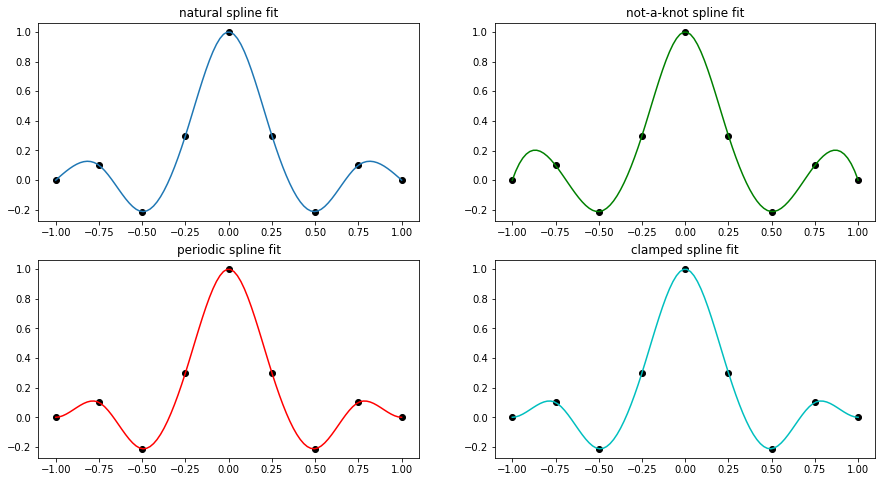

In [176]:
n=8; 
xi=np.linspace(-1,1,n+1);
fi=g2(xi); 
uspl = CubicSpline(xi,fi,bc_type='natural');
y=np.linspace(-1,1,100); 

fig, axs  = plt.subplots(2, 2);
axs[0,0].plot(xi,fi,'ok')
axs[0,0].plot(y,uspl(y))
axs[0,0].set_title('natural spline fit')

uspl2 = CubicSpline(xi,fi,bc_type='not-a-knot');
axs[0,1].plot(xi,fi,'ok')
axs[0,1].plot(y,uspl2(y),'g')
axs[0,1].set_title('not-a-knot spline fit')

uspl3 = CubicSpline(xi,fi,bc_type='periodic');
axs[1,0].plot(xi,fi,'ok')
axs[1,0].plot(y,uspl3(y),'r')
axs[1,0].set_title('periodic spline fit')

uspl4 = CubicSpline(xi,fi,bc_type='clamped');
axs[1,1].plot(xi,fi,'ok')
axs[1,1].plot(y,uspl4(y),'c')
axs[1,1].set_title('clamped spline fit')


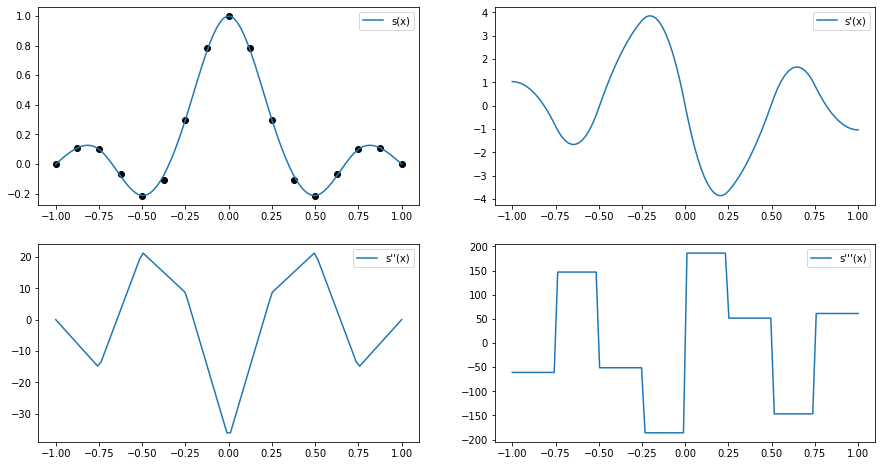

In [194]:
fig, axs  = plt.subplots(2, 2);
axs[0,0].plot(xi,g2(xi),'ok');
y=np.linspace(-1,1,100); 
axs[0,0].plot(y,uspl(y),label='s(x)'); axs[0,0].legend(); 
axs[0,1].plot(y,uspl(y,1),label="s'(x)"); axs[0,1].legend();
axs[1,0].plot(y,uspl(y,2),label="s''(x)"); axs[1,0].legend();
axs[1,1].plot(y,uspl(y,3),label="s'''(x)"); axs[1,1].legend();

Text(0.5, 1.0, 'antiderivative of uspl')

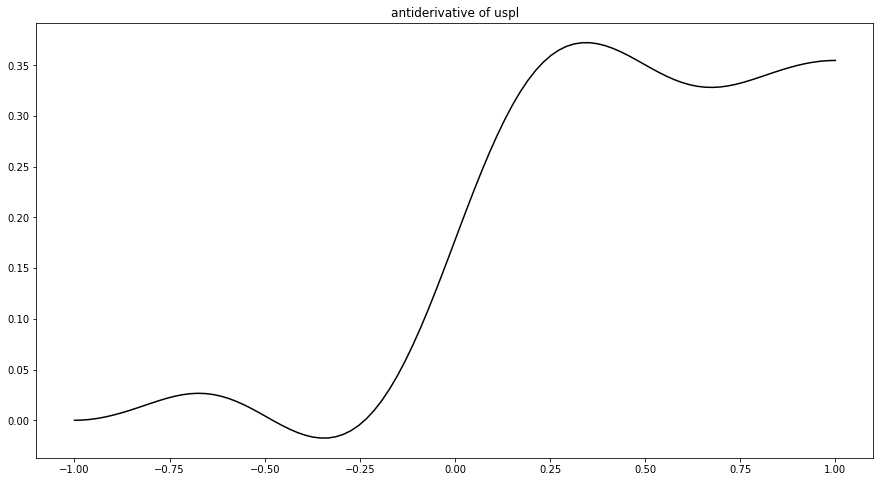

In [200]:
usplint = uspl.antiderivative(1); 
plt.plot(y,usplint(y),'k')
plt.title('antiderivative of uspl')

### Scipy.Interpolation splrep and splev (Bspline fit and evaluation)

[-1.    -1.    -1.    -1.    -0.75  -0.625 -0.5   -0.375 -0.25  -0.125
  0.     0.125  0.25   0.375  0.5    0.625  0.75   1.     1.     1.
  1.   ]
[0.09090909 0.10499849 0.13117064 0.19921296 0.27789686 0.40348531
 0.6016684  0.8821488  1.0589256  0.8821488  0.6016684  0.40348531
 0.27789686 0.19921296 0.13117064 0.10499849 0.09090909 0.
 0.         0.         0.        ]
3


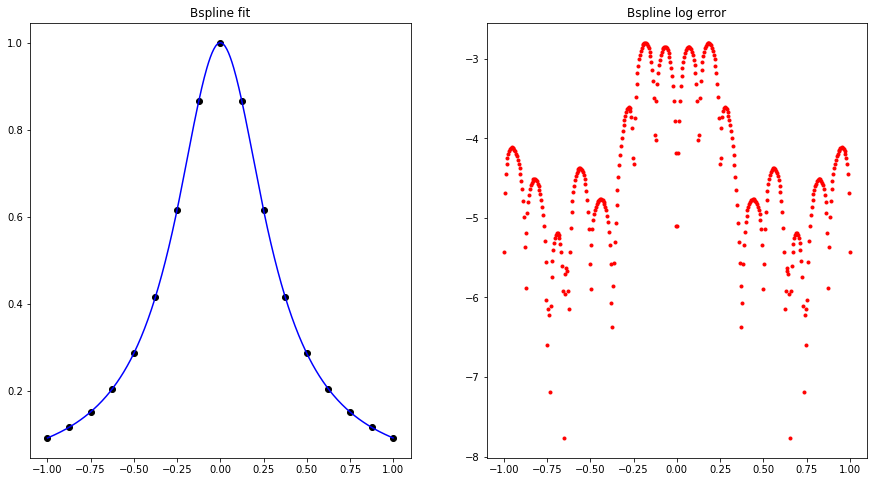

In [179]:
n=16; 
xi=np.linspace(-1,1,n+1);
fi=g(xi); 
y=np.linspace(-0.999,0.999,400); 
spl = splrep(xi,fi);
print(spl[0]); 
print(spl[1]);
print(spl[2]);
sy = splev(y,spl);
fig, (ax1, ax2)  = plt.subplots(1, 2);
ax1.plot(xi,fi,'ok'); 
ax1.plot(y,sy,'b');
ax1.set_title('Bspline fit')
ax2.plot(y,np.log10(np.abs(sy-fun(y))),'.r');
ax2.set_title('Bspline log error');

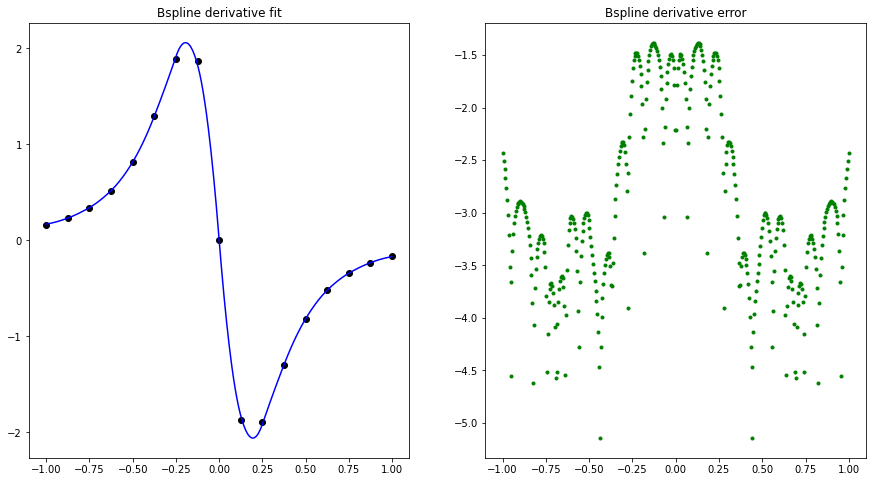

In [181]:
def dfun(x):
    return -20*x/(1+10*x**2)**2;
dsy = splev(y,spl,1);
fig, (ax1, ax2)  = plt.subplots(1, 2);
ax1.plot(xi,dfun(xi),'ok'); 
ax1.plot(y,dsy,'b');
ax1.set_title('Bspline derivative fit')
ax2.plot(y,np.log10(np.abs(dsy-dfun(y))),'.g');
ax2.set_title('Bspline derivative error');